In [3]:
# train_td3.py
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import os

from tqdm import tqdm
import gym

# Import your TD3 components
from memory import ReplayBuffer
from td3 import TD3

In [4]:
# Define the list of environments to evaluate
env_names = ["Pendulum-v1", "MountainCarContinuous-v0"]

# Define a base seed for reproducibility
base_seed = 42

# Initialize a dictionary to store environment details
env_details = {}

for env_name in env_names:
    env = gym.make(env_name)
    
    # Set seeds for reproducibility
    env.seed(base_seed)
    env.action_space.seed(base_seed)
    torch.manual_seed(base_seed)
    np.random.seed(base_seed)
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    env_details[env_name] = {
        "env": env,
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action
    }
    
    print(f"Environment: {env_name}")
    print(f"  State Dimension: {state_dim}")
    print(f"  Action Dimension: {action_dim}")
    print(f"  Max Action: {max_action}\n")

Environment: Pendulum-v1
  State Dimension: 3
  Action Dimension: 1
  Max Action: 2.0

Environment: MountainCarContinuous-v0
  State Dimension: 2
  Action Dimension: 1
  Max Action: 1.0



In [5]:
# Define unified training configuration
training_config = {
    "discount": 0.99,
    "tau": 0.005,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "policy_freq": 2,
    "max_episodes": 10000,           # Total training episodes per environment
    "start_timesteps": 1000,       # Number of initial random steps
    "eval_freq": 50,               # How often to evaluate the policy (in episodes)
    "batch_size": 256,             # Batch size for training
    "expl_noise_type": "pink", # Type of exploration noise: "gaussian", "pink", or "ou"
    "expl_noise": 0.1,             # Exploration noise scale
    "pink_noise_params": {         # Pink noise specific parameters
        "exponent": 1.0,            # Exponent for pink noise (1.0 for pink)
        "fmin": 0.0                 # Low-frequency cutoff
    },
    "ou_noise_params": {           # OU noise specific parameters
        "mu": 0.0,
        "theta": 0.15,
        "sigma": 0.2
    },
    "use_layer_norm": True,        # Toggle LayerNorm on/off
    "ln_eps": 1e-5,                  # LayerNorm epsilon
    "save_model": True,             # Whether to save the model
    "save_model_freq": 100,         # How often to save the model (in episodes)
    "use_rnd": True,                # Toggle RND on/off
    "rnd_weight": 1.0,              # Weight for intrinsic rewards
    "rnd_lr": 1e-4,                 # Learning rate for RND predictor
    "rnd_hidden_dim": 128,          # Hidden dimension for RND networks
    "max_episode_steps": 1000       # Max steps per episode (adjust as needed)
}

# Directory setup
base_results_dir = "./results"
base_models_dir = "./models"

os.makedirs(base_results_dir, exist_ok=True)
os.makedirs(base_models_dir, exist_ok=True)

In [6]:
# Initialize a dictionary to store agents and replay buffers
agents = {}
replay_buffers = {}

for env_name, details in env_details.items():
    state_dim = details["state_dim"]
    action_dim = details["action_dim"]
    max_action = details["max_action"]
    
    # Initialize TD3 agent with integrated noise
    agent = TD3(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        training_config=training_config
    )
    
    agents[env_name] = agent
    
    # Initialize Replay Buffer
    replay_buffer = ReplayBuffer(state_dim, action_dim, max_size=int(1e6))
    replay_buffers[env_name] = replay_buffer

    print(f"Initialized TD3 agent and Replay Buffer for {env_name}")

Initialized TD3 agent and Replay Buffer for Pendulum-v1
Initialized TD3 agent and Replay Buffer for MountainCarContinuous-v0


In [7]:
def eval_policy(policy, env, seed, eval_episodes=10):
    """
    Evaluates the policy over a number of episodes.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to evaluate on.
        seed (int): The seed for reproducibility.
        eval_episodes (int): Number of episodes to evaluate.

    Returns:
        list: List of episode rewards.
    """
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 100)
    eval_env.action_space.seed(seed + 100)

    # Set networks to eval mode
    policy.actor.eval()
    policy.critic.eval()

    episode_rewards = []
    with torch.no_grad():
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            episode_reward = 0
            while not done:
                action = policy.act(np.array(state), add_noise=False)
                state, reward, done, _ = eval_env.step(action)
                episode_reward += reward
            episode_rewards.append(episode_reward)

    # Restore networks to train mode
    policy.actor.train()
    policy.critic.train()

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: Rewards: {episode_rewards}")
    print("---------------------------------------")
    return episode_rewards

def evaluate_trained_actor(policy, env, seed, eval_episodes=100):
    """
    Evaluates the trained actor over 100 episodes and computes mean and std of rewards.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to evaluate on.
        seed (int): The seed for reproducibility.
        eval_episodes (int): Number of episodes to evaluate.

    Returns:
        tuple: (list of episode rewards, mean reward, std reward)
    """
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 200)
    eval_env.action_space.seed(seed + 200)

    policy.actor.eval()

    episode_rewards = []
    with torch.no_grad():
        for episode in range(eval_episodes):
            state, done = eval_env.reset(), False
            episode_reward = 0
            while not done:
                action = policy.act(np.array(state), add_noise=False)
                state, reward, done, _ = eval_env.step(action)
                episode_reward += reward
            episode_rewards.append(episode_reward)
            if (episode + 1) % 10 == 0:
                print(f"Completed {episode + 1}/{eval_episodes} episodes.")

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print("---------------------------------------")
    print(f"Final Evaluation over {eval_episodes} episodes: Mean Reward: {mean_reward:.3f}, Std: {std_reward:.3f}")
    print("---------------------------------------")
    return episode_rewards, mean_reward, std_reward

In [8]:
# Initialize dictionaries to store results
evaluation_results = {}
loss_results = {
    env_name: {
        "critic_loss": [],
        "actor_loss": []
    } for env_name in env_details.keys()
}
final_evaluation_results = {}

for env_name, details in env_details.items():
    print(f"\n===========================\nTraining on {env_name}\n===========================")
    
    env = details["env"]
    state_dim = details["state_dim"]
    action_dim = details["action_dim"]
    max_action = details["max_action"]
    
    agent = agents[env_name]
    replay_buffer = replay_buffers[env_name]
    
    # Define file-specific directories
    file_name = f"TD3_{env_name.replace('-', '_')}_{base_seed}"
    results_dir = os.path.join(base_results_dir, env_name.replace('-', '_'))
    models_dir = os.path.join(base_models_dir, env_name.replace('-', '_'))
    
    os.makedirs(results_dir, exist_ok=True)
    if training_config["save_model"]:
        os.makedirs(models_dir, exist_ok=True)
    
    # Evaluate untrained policy
    print("Evaluating untrained policy...")
    initial_evaluations = eval_policy(agent, env, base_seed, eval_episodes=10)
    evaluations = initial_evaluations.copy()
    
    total_timesteps = 0  # To track total timesteps if needed
    
    # Progress bar for episodes
    pbar = tqdm(total=training_config["max_episodes"], desc=f"Training {env_name}")
    
    for episode in range(1, training_config["max_episodes"] + 1):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        
        # Reset noise generator if using OU Noise
        if training_config["expl_noise_type"].lower() == "ou" and hasattr(agent, 'ou_noise'):
            agent.ou_noise.reset()
        
        # Reset noise generator if using Pink Noise
        if training_config["expl_noise_type"].lower() == "pink" and hasattr(agent, 'pink_noise'):
            agent.pink_noise.reset()
        
        # Reset loss accumulators
        cumulative_critic_loss = 0.0
        cumulative_actor_loss = 0.0
        loss_steps = 0
        actor_loss_steps = 0
        
        while not done:
            episode_timesteps += 1
            total_timesteps += 1
            
            # Select action with exploration noise handled internally
            if total_timesteps < training_config["start_timesteps"]:
                action = env.action_space.sample()
            else:
                action = agent.act(np.array(state), add_noise=True)
            
            # Perform action
            next_state, reward, done, _ = env.step(action)
            done_bool = float(done) if episode_timesteps < training_config["max_episode_steps"] else 0
            
            # Store data in replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)
            
            state = next_state
            episode_reward += reward
            
            # Train agent after collecting sufficient data
            if total_timesteps >= training_config["start_timesteps"]:
                critic_loss, actor_loss = agent.train(replay_buffer, training_config["batch_size"])
                cumulative_critic_loss += critic_loss
                loss_steps += 1
                if actor_loss is not None:
                    cumulative_actor_loss += actor_loss
                    actor_loss_steps += 1
        
        # Compute average losses for the episode
        avg_critic_loss = cumulative_critic_loss / loss_steps if loss_steps > 0 else 0
        avg_actor_loss = cumulative_actor_loss / actor_loss_steps if actor_loss_steps > 0 else 0
        
        # Append the average losses to the loss_results dictionary
        loss_results[env_name]["critic_loss"].append(avg_critic_loss)
        loss_results[env_name]["actor_loss"].append(avg_actor_loss)
        
        # Append the episode reward
        evaluations.append(episode_reward)
        
        # Update the progress bar
        pbar.update(1)
        
        # Evaluate the policy at specified intervals
        if episode % training_config["eval_freq"] == 0:
            print(f"Evaluating policy at episode {episode}...")
            eval_rewards = eval_policy(agent, env, base_seed, eval_episodes=10)
            evaluations.extend(eval_rewards)  # Append evaluation rewards to the list
            np.save(os.path.join(results_dir, file_name), evaluations)
            if training_config["save_model"] and (episode % training_config["save_model_freq"] == 0):
                agent.save(os.path.join(models_dir, file_name))
        
        # Optionally, save the model at the end of training
        if training_config["save_model"] and (episode == training_config["max_episodes"]):
            agent.save(os.path.join(models_dir, file_name))
    
    pbar.close()
    
    # Store evaluations for plotting later
    evaluation_results[env_name] = evaluations


Training on Pendulum-v1
Evaluating untrained policy...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-1431.158075604773, -1391.0529496864476, -1645.2609219742255, -1593.6801202291608, -1634.2729037466129, -1697.1217426386595, -1102.9597722287926, -1622.3250914562734, -1526.5359087071145, -1539.1747888627683]
---------------------------------------


Training Pendulum-v1:   0%|          | 50/10000 [00:45<2:47:10,  1.01s/it]

Evaluating policy at episode 50...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-127.0130272095957, -1172.4124036428755, -251.43044959113146, -256.21166341786426, -264.08057722553446, -246.01453933832443, -131.11534505122427, -251.320136149432, -133.2033897875761, -133.2335450342282]
---------------------------------------


Training Pendulum-v1:   1%|          | 56/10000 [00:51<2:51:08,  1.03s/it]

KeyboardInterrupt: 

In [7]:
def plot_noise_comparison(env_name, agent, training_config):
    if training_config["expl_noise_type"].lower() not in ["pink", "ou"]:
        print(f"No noise comparison plot available for noise type: {training_config['expl_noise_type']}")
        return
    
    max_steps = training_config.get("max_episode_steps", 1000)
    action_dim = env_details[env_name]["env"].action_space.shape[0]
    
    # Generate noise sequence
    noise_sequence = []
    for _ in range(max_steps):
        if training_config["expl_noise_type"].lower() == "pink":
            noise = agent.pink_noise.get_noise() * training_config["expl_noise"]
        elif training_config["expl_noise_type"].lower() == "ou":
            noise = agent.ou_noise.sample() * training_config["expl_noise"]
        noise_sequence.append(noise)
    noise_sequence = np.array(noise_sequence)
    
    # Generate Gaussian noise for comparison
    gaussian_noise_sequence = np.random.normal(0, training_config["expl_noise"], size=(max_steps, action_dim))
    
    # Plot for each action dimension
    for dim in range(action_dim):
        plt.figure(figsize=(12, 4))
        plt.plot(noise_sequence[:, dim], label=f'{training_config["expl_noise_type"].capitalize()} Noise')
        plt.plot(gaussian_noise_sequence[:, dim], label='Gaussian Noise', alpha=0.7)
        plt.title(f'Noise Comparison for Action Dimension {dim} in {env_name}')
        plt.xlabel('Step')
        plt.ylabel('Noise Value')
        plt.legend()
        plt.grid(True)
        plt.show()

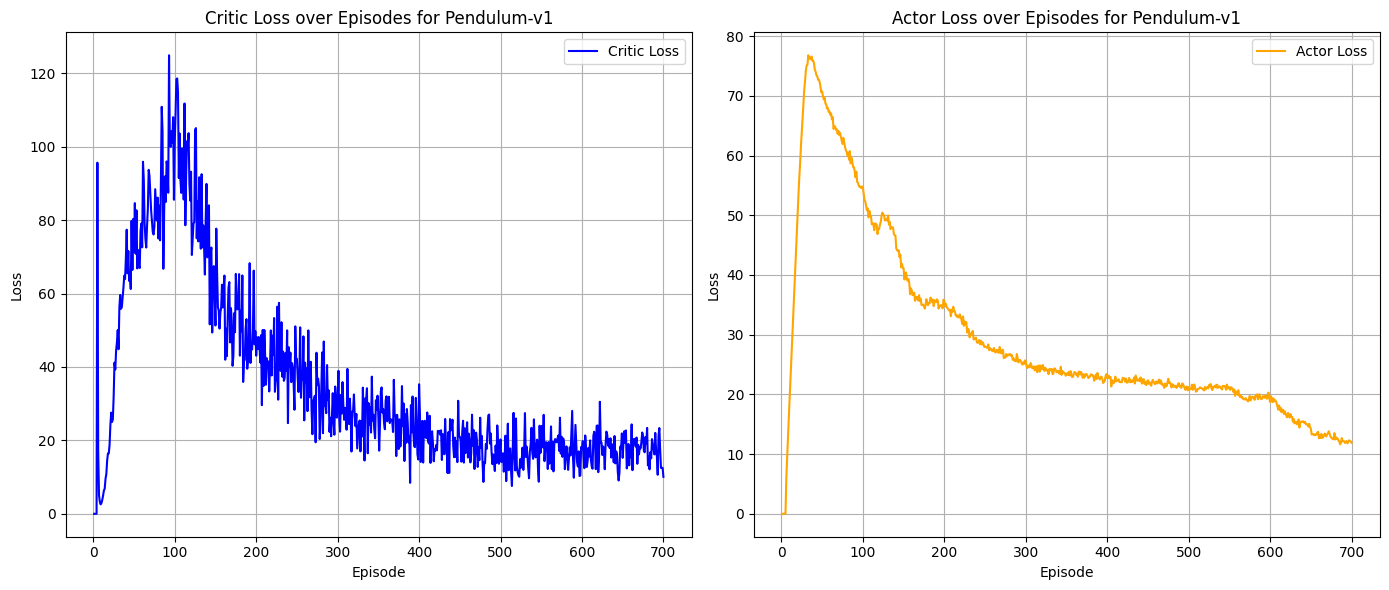

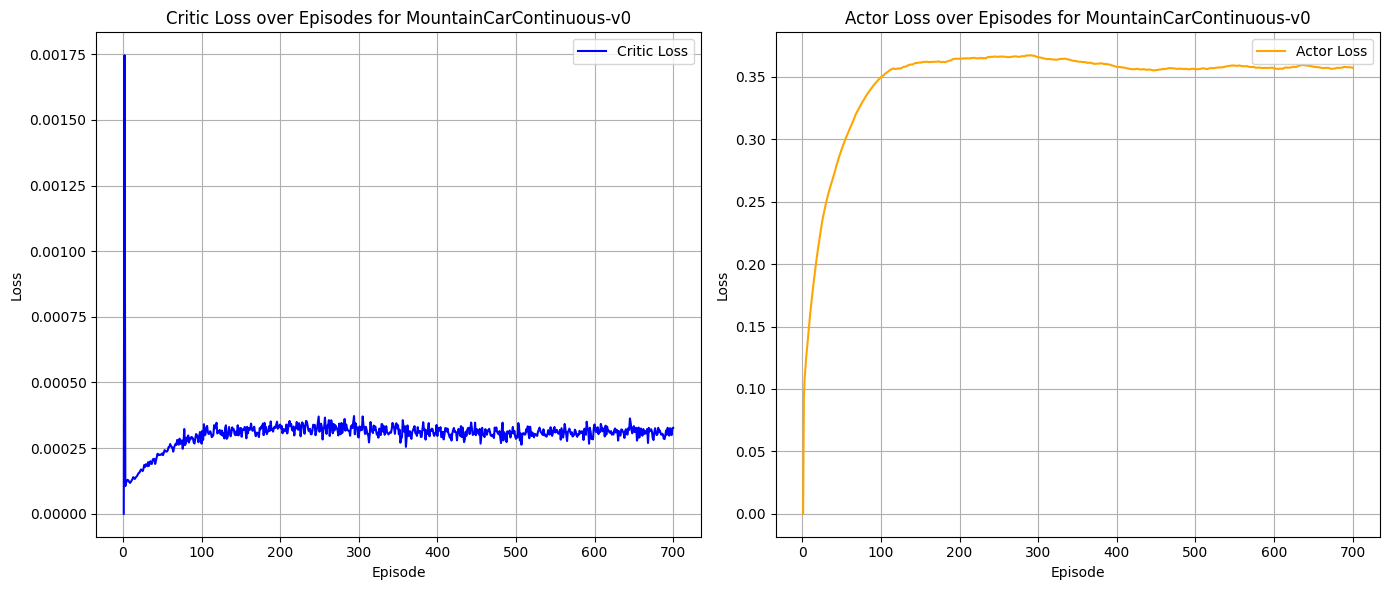

In [8]:
def plot_losses(env_name, loss_data):
    episodes = range(1, len(loss_data["critic_loss"]) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Critic Loss
    plt.subplot(1, 2, 1)
    plt.plot(episodes, loss_data["critic_loss"], label='Critic Loss', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(f'Critic Loss over Episodes for {env_name}')
    plt.legend()
    plt.grid(True)
    
    # Plot Actor Loss
    plt.subplot(1, 2, 2)
    plt.plot(episodes, loss_data["actor_loss"], label='Actor Loss', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(f'Actor Loss over Episodes for {env_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plotting the loss curves for each environment
for env_name, loss_data in loss_results.items():
    plot_losses(env_name, loss_data)

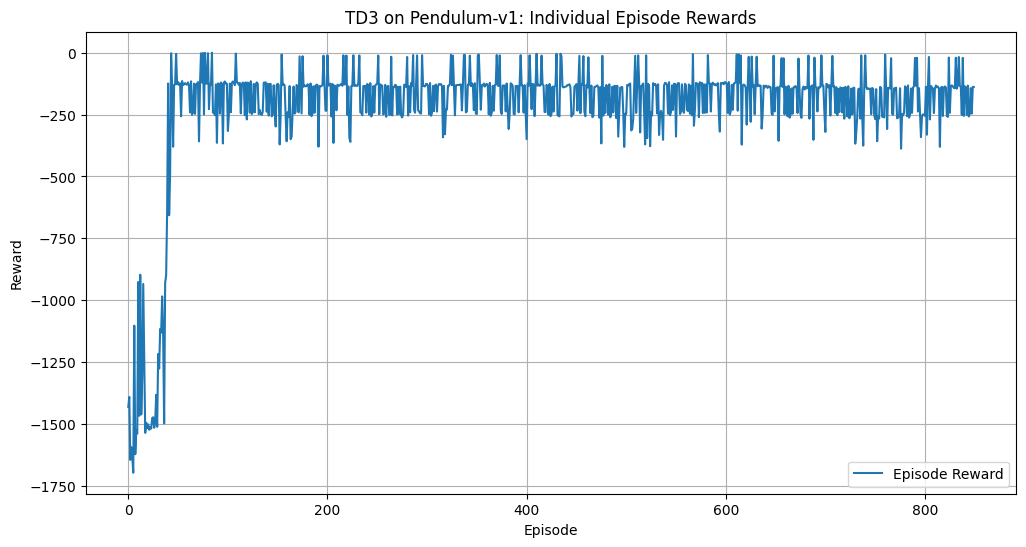

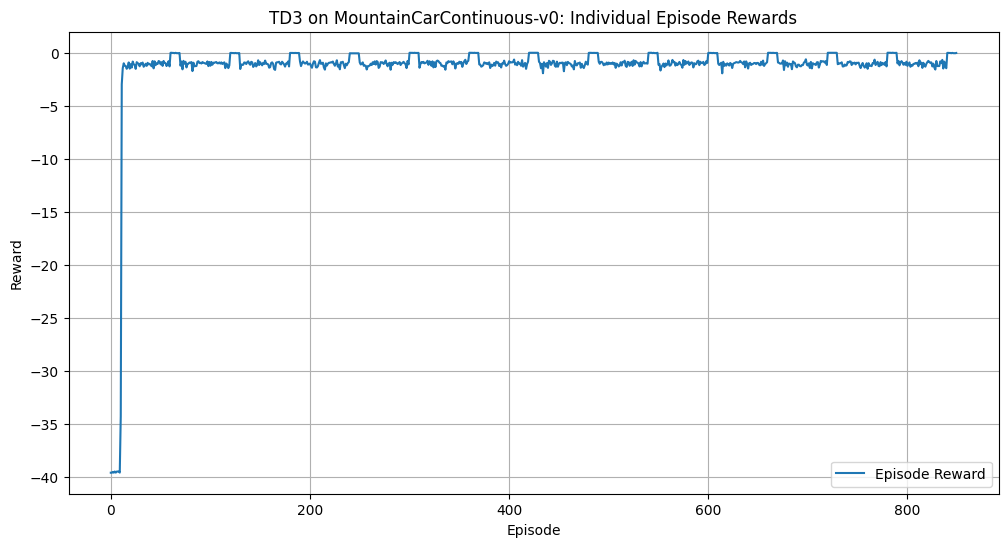

In [9]:
# Plotting individual episode rewards for each environment
for env_name, rewards in evaluation_results.items():
    plt.figure(figsize=(12,6))
    plt.plot(rewards, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'TD3 on {env_name}: Individual Episode Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

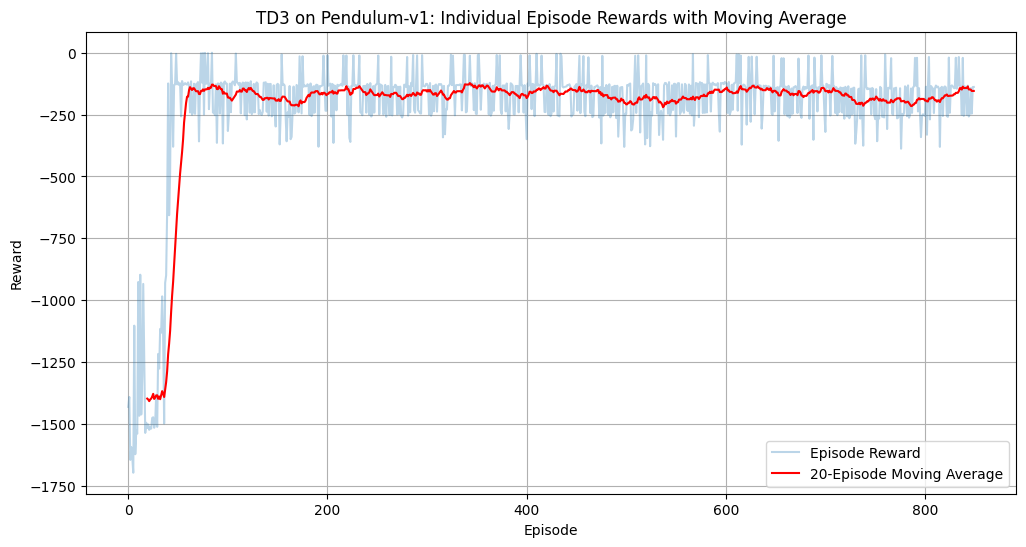

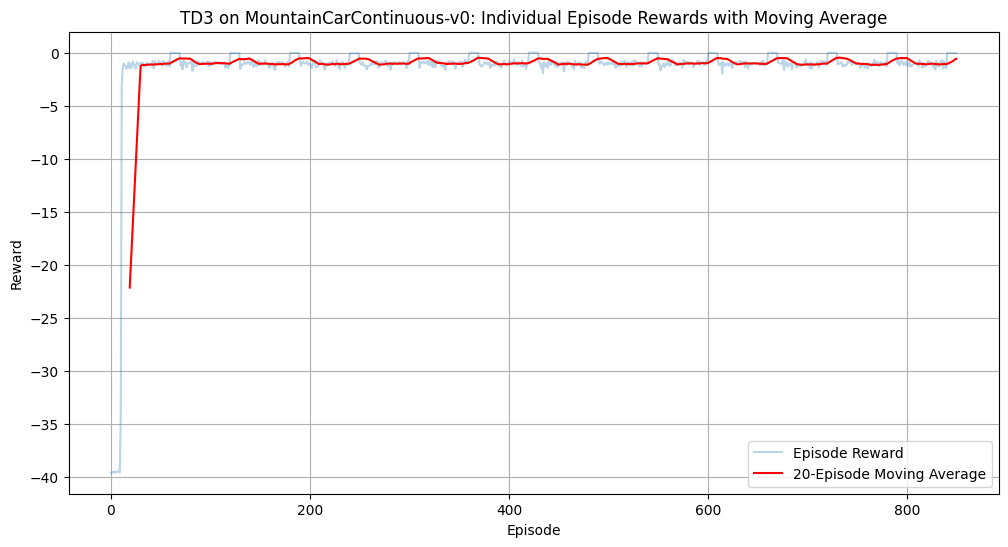

In [10]:
# Moving average for smoother visualization
window = 20

for env_name, rewards in evaluation_results.items():
    plt.figure(figsize=(12,6))
    plt.plot(rewards, label='Episode Reward', alpha=0.3)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), moving_avg, label=f'{window}-Episode Moving Average', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'TD3 on {env_name}: Individual Episode Rewards with Moving Average')
    plt.legend()
    plt.grid(True)
    plt.show()



Final Evaluation on Pendulum-v1
Completed 10/100 episodes.
Completed 20/100 episodes.
Completed 30/100 episodes.
Completed 40/100 episodes.
Completed 50/100 episodes.
Completed 60/100 episodes.
Completed 70/100 episodes.
Completed 80/100 episodes.
Completed 90/100 episodes.
Completed 100/100 episodes.
---------------------------------------
Final Evaluation over 100 episodes: Mean Reward: -167.517, Std: 80.668
---------------------------------------


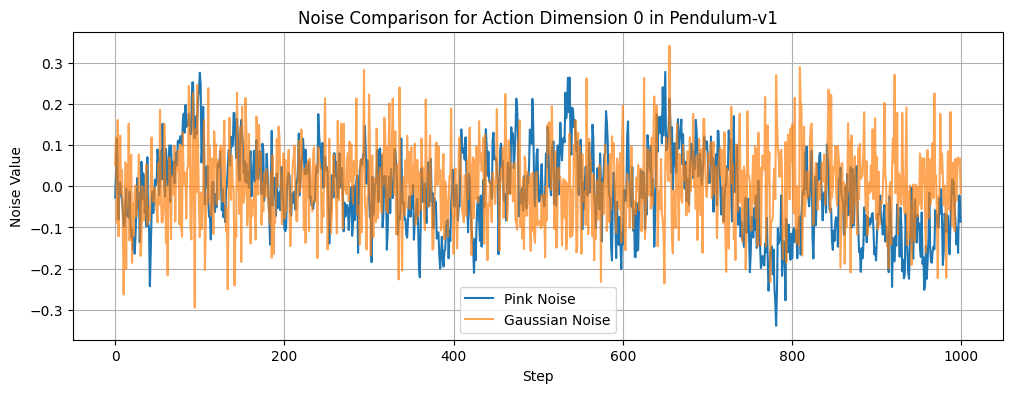


Final Evaluation on MountainCarContinuous-v0
Completed 10/100 episodes.
Completed 20/100 episodes.
Completed 30/100 episodes.
Completed 40/100 episodes.
Completed 50/100 episodes.
Completed 60/100 episodes.
Completed 70/100 episodes.
Completed 80/100 episodes.
Completed 90/100 episodes.
Completed 100/100 episodes.
---------------------------------------
Final Evaluation over 100 episodes: Mean Reward: -0.028, Std: 0.014
---------------------------------------


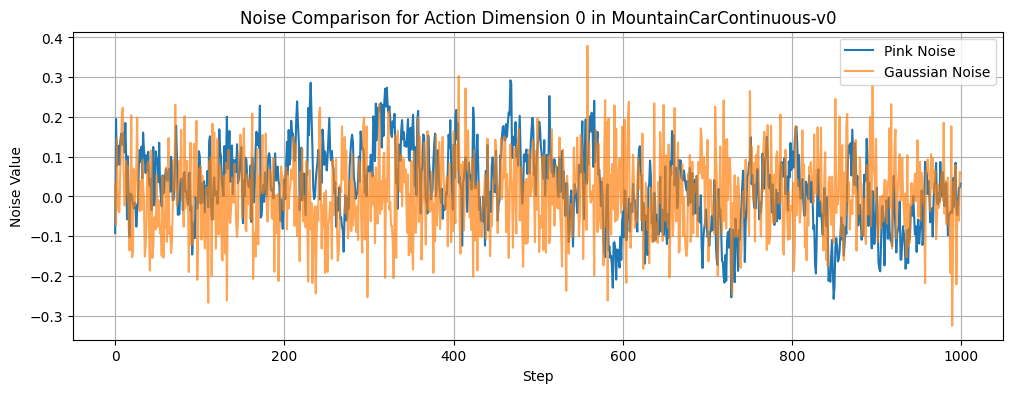

In [11]:
# Final Evaluation
for env_name, details in env_details.items():
    print(f"\n===========================\nFinal Evaluation on {env_name}\n===========================")
    
    env = details["env"]
    agent = agents[env_name]
    
    # Define file-specific directories
    file_name = f"TD3_{env_name.replace('-', '_')}_{base_seed}"
    results_dir = os.path.join(base_results_dir, env_name.replace('-', '_'))
    models_dir = os.path.join(base_models_dir, env_name.replace('-', '_'))
    
    # Evaluate the trained actor
    final_episode_rewards, final_mean_reward, final_std_reward = evaluate_trained_actor(agent, env, base_seed, eval_episodes=100)
    
    # Store the results
    final_evaluation_results[env_name] = {
        "rewards": final_episode_rewards,
        "mean_reward": final_mean_reward,
        "std_reward": final_std_reward
    }

    # Optionally, plot noise comparison if applicable
    plot_noise_comparison(env_name, agent, training_config)

In [12]:
def render_episodes(policy, env, seed, episodes=5, render=True):
    """
    Renders the agent interacting with the environment.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to visualize.
        seed (int): Seed for reproducibility.
        episodes (int): Number of episodes to render.
        render (bool): Whether to render the environment.

    Returns:
        None
    """
    import copy
    import torch

    # Create a deep copy of the environment for rendering
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 300)
    eval_env.action_space.seed(seed + 300)
    torch.manual_seed(seed + 300)

    # Set Actor and Critic to eval mode
    policy.actor.eval()
    policy.critic.eval()

    for ep in range(1, episodes + 1):
        state = eval_env.reset()
        done = False
        episode_reward = 0
        while not done:
            if render:
                eval_env.render()

            # Select action without exploration noise
            action = policy.act(np.array(state))
            
            # Take action in the environment
            state, reward, done, _ = eval_env.step(action)
            episode_reward += reward

        print(f"Episode {ep}: Reward = {episode_reward}")

    # Close the rendering window if necessary
    eval_env.close()

    # Restore Actor and Critic to train mode
    policy.actor.train()
    policy.critic.train()


In [13]:
# After training is complete

for env_name, details in env_details.items():
    env = details["env"]
    agent = agents[env_name]
    print(f"\nRendering episodes for {env_name}...")
    render_episodes(agent, env, base_seed, episodes=3, render=True)



Rendering episodes for Pendulum-v1...


NoSuchDisplayException: Cannot connect to "None"